### Exercise 1

Try clustering the iris data using k-means.  Try different numbers of clusters. Print the confusion matrix that compares the cluster labels with the actual labels.

In [1]:
# @SHOW
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target

In [4]:
# Your code here
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.optimize import linear_sum_assignment

# Load the data
iris = load_iris()
X = iris.data
y_true = iris.target  # ground truth labels (0=setosa, 1=versicolor, 2=virginica)

# Standardize features (important for KMeans)
X = StandardScaler().fit_transform(X)

def cluster_and_confusion(k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X)

    # Align cluster labels with true labels (since KMeans labels are arbitrary)
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)  # Hungarian algorithm
    aligned_cm = cm[:, col_ind]
    
     # Relabel predictions based on alignment
    label_map = dict(zip(col_ind, row_ind))
    y_aligned = np.array([label_map[label] for label in y_pred])

    ari = adjusted_rand_score(y_true, y_aligned)

    print(f"\nK = {k}")
    print("Confusion matrix (rows=true classes, cols=aligned clusters):")
    print(aligned_cm)
    print(f"ARI: {ari:.3f}")

# Try different k
for k in [2, 3, 4, 5]:
    cluster_and_confusion(k)


K = 2
Confusion matrix (rows=true classes, cols=aligned clusters):
[[50  0  0]
 [ 0 50  0]
 [ 0 50  0]]
ARI: 0.568

K = 3
Confusion matrix (rows=true classes, cols=aligned clusters):
[[50  0  0]
 [ 0 39 11]
 [ 0 14 36]]
ARI: 0.620

K = 4
Confusion matrix (rows=true classes, cols=aligned clusters):
[[28  0  0 22]
 [ 0 39 11  0]
 [ 0 14 36  0]
 [ 0  0  0  0]]
ARI: 0.473

K = 5
Confusion matrix (rows=true classes, cols=aligned clusters):
[[28  0  0  0 22]
 [ 0 28  0 22  0]
 [ 0 20 27  3  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
ARI: 0.435


What seems to give the best clustering according to ground truth?  How do you know?

According to the ground truth, the 3-cluster solution is best because ARI = 0.620 is the highest among all clustering methods, and it shows moderate-to-strong alignment with the true labels. The confusion matrix confirms that class 1 is perfectly identified, while classes 2 and 3 are mostly separated but partly overlapping.In contrast, the other cluster solutions would merge distinct classes or split the perfect class, worsening alignment with reality.

### Exercise 2


Use the elbow method, the silhouette method, and the Davies-Bouldin method to evaluate your clustering results for different k from the previous problem.

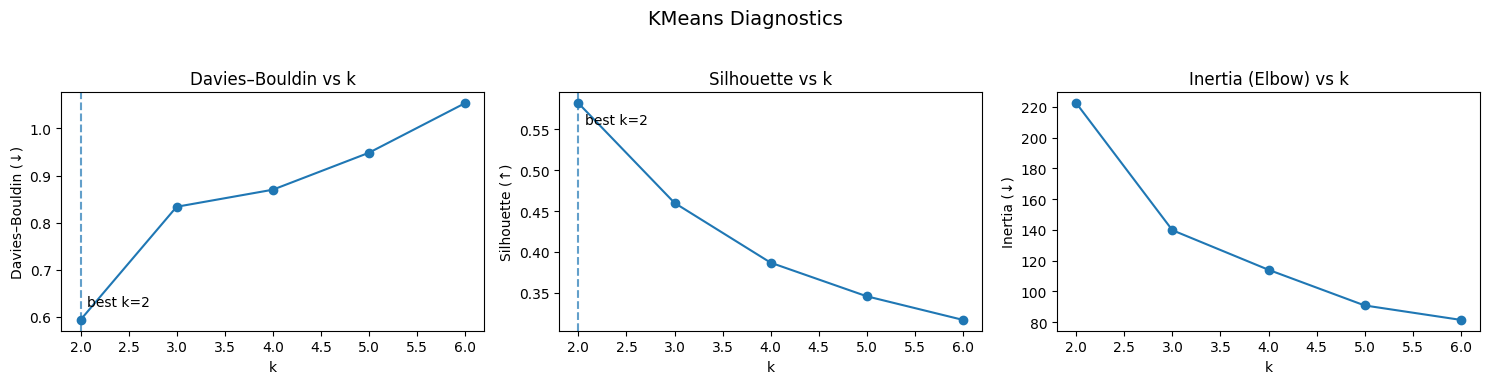

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def plot_kmeans_diagnostics(
    X,
    k_min=2,
    k_max=10,
    title="KMeans Diagnostics",
    random_state=42,
    n_init=10,
    max_iter=300,
    figsize=(15, 4),
):
    """
    Evaluate KMeans clustering using Inertia (elbow), Silhouette, and Davies–Bouldin.
    Plots the results and highlights the best k values for silhouette and DB index.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Data matrix.
    k_min, k_max : int
        Inclusive range of k values to evaluate.
    title : str
        Figure title.
    random_state : int
        Random seed for reproducibility.
    n_init : int
        Number of initializations for KMeans.
    max_iter : int
        Max iterations for KMeans.
    figsize : tuple
        Figure size.

    Returns
    -------
    scores_df : pandas.DataFrame
        Columns: ['k', 'inertia', 'silhouette', 'davies_bouldin']
    """
    results = []
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(
            n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter
        )
        labels = kmeans.fit_predict(X)

        inertia = kmeans.inertia_
        sil = silhouette_score(X, labels) if 1 < k < len(X) else np.nan
        db = davies_bouldin_score(X, labels) if k > 1 else np.nan

        results.append({"k": k, "inertia": inertia, "silhouette": sil, "davies_bouldin": db})

    scores_df = pd.DataFrame(results)

    # Identify best Ks (ignoring NaNs)
    k_best_sil = scores_df.loc[scores_df["silhouette"].idxmax(), "k"] if scores_df["silhouette"].notna().any() else None
    k_best_db = scores_df.loc[scores_df["davies_bouldin"].idxmin(), "k"] if scores_df["davies_bouldin"].notna().any() else None

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(title, fontsize=14)

    # Davies–Bouldin (lower is better)
    ax = axes[0]
    ax.plot(scores_df["k"], scores_df["davies_bouldin"], marker="o")
    ax.set_xlabel("k")
    ax.set_ylabel("Davies–Bouldin (↓)")
    ax.set_title("Davies–Bouldin vs k")
    if k_best_db is not None:
        ax.axvline(k_best_db, linestyle="--", alpha=0.7)
        ax.annotate(f"best k={k_best_db}", 
                    xy=(k_best_db, np.nanmin(scores_df["davies_bouldin"])),
                    xytext=(5, 10), textcoords="offset points")

    # Silhouette (higher is better)
    ax = axes[1]
    ax.plot(scores_df["k"], scores_df["silhouette"], marker="o")
    ax.set_xlabel("k")
    ax.set_ylabel("Silhouette (↑)")
    ax.set_title("Silhouette vs k")
    if k_best_sil is not None:
        ax.axvline(k_best_sil, linestyle="--", alpha=0.7)
        ax.annotate(f"best k={k_best_sil}", 
                    xy=(k_best_sil, np.nanmax(scores_df["silhouette"])),
                    xytext=(5, -15), textcoords="offset points")

    # Inertia (elbow)
    ax = axes[2]
    ax.plot(scores_df["k"], scores_df["inertia"], marker="o")
    ax.set_xlabel("k")
    ax.set_ylabel("Inertia (↓)")
    ax.set_title("Inertia (Elbow) vs k")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return scores_df
plot_kmeans_diagnostics(X, k_min=2, k_max=6, title="KMeans Diagnostics")

k = 3
labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)

# One-liner Hungarian remap so confusion matrix aligns with true classes
cost = -confusion_matrix(y, labels)
r, c = linear_sum_assignment(cost)
mapping = dict(zip(c, r))
labels_mapped = np.vectorize(mapping.get)(labels)

Do the data-driven methods provide clear guidance?

So, there is no clear “elbow”, and both Silhouette and Davies-Bouldin recoommended 2 clusters, which, from ground truth (the ARI confusion matrices earlier), we know that the true answer is k=3. This mismatch happens because versicolor and virginica overlap strongly in feature space. Internal methods are biased toward finding the “cleanest” separation, which collapses them together.
So while the data-driven methods are consistent (they all say k=2), they don’t give clear or correct guidance compared to the ground truth.

### Exercise 3
<!-- @q -->

The following plot contains five clusters.  Use HAC with different linkage and K-means with data-driven evaluation metrics to try to determine the number of clusters if you *didn't* know the answer already.

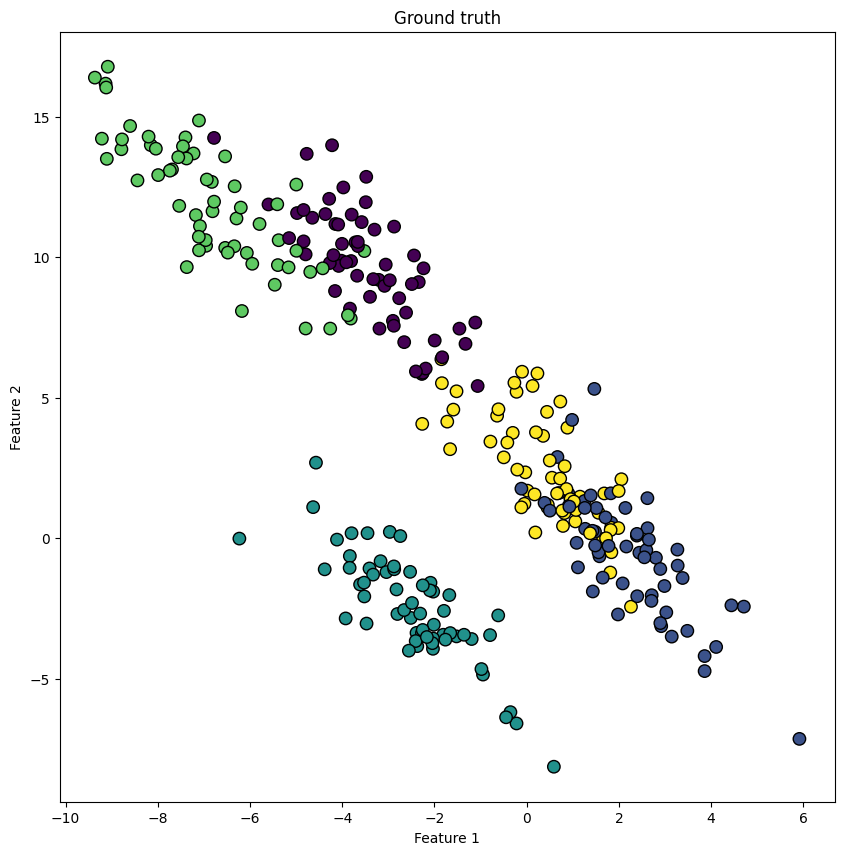

In [20]:
# @SHOW

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Generate synthetic data with spherical clusters
X, y = make_blobs(n_samples=300, centers=5, cluster_std=2.0,random_state=42)

# Stretch and rotate some of the blobs to create elliptical clusters
transformation_matrix = np.array([[0.6, -0.6], [-0.2, 0.9]])
X_aniso = np.dot(X, transformation_matrix)


# Plotting
plt.figure(figsize=(10, 10))

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y, cmap='viridis', marker='o', edgecolors='k', s=80)
plt.title('Ground truth')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


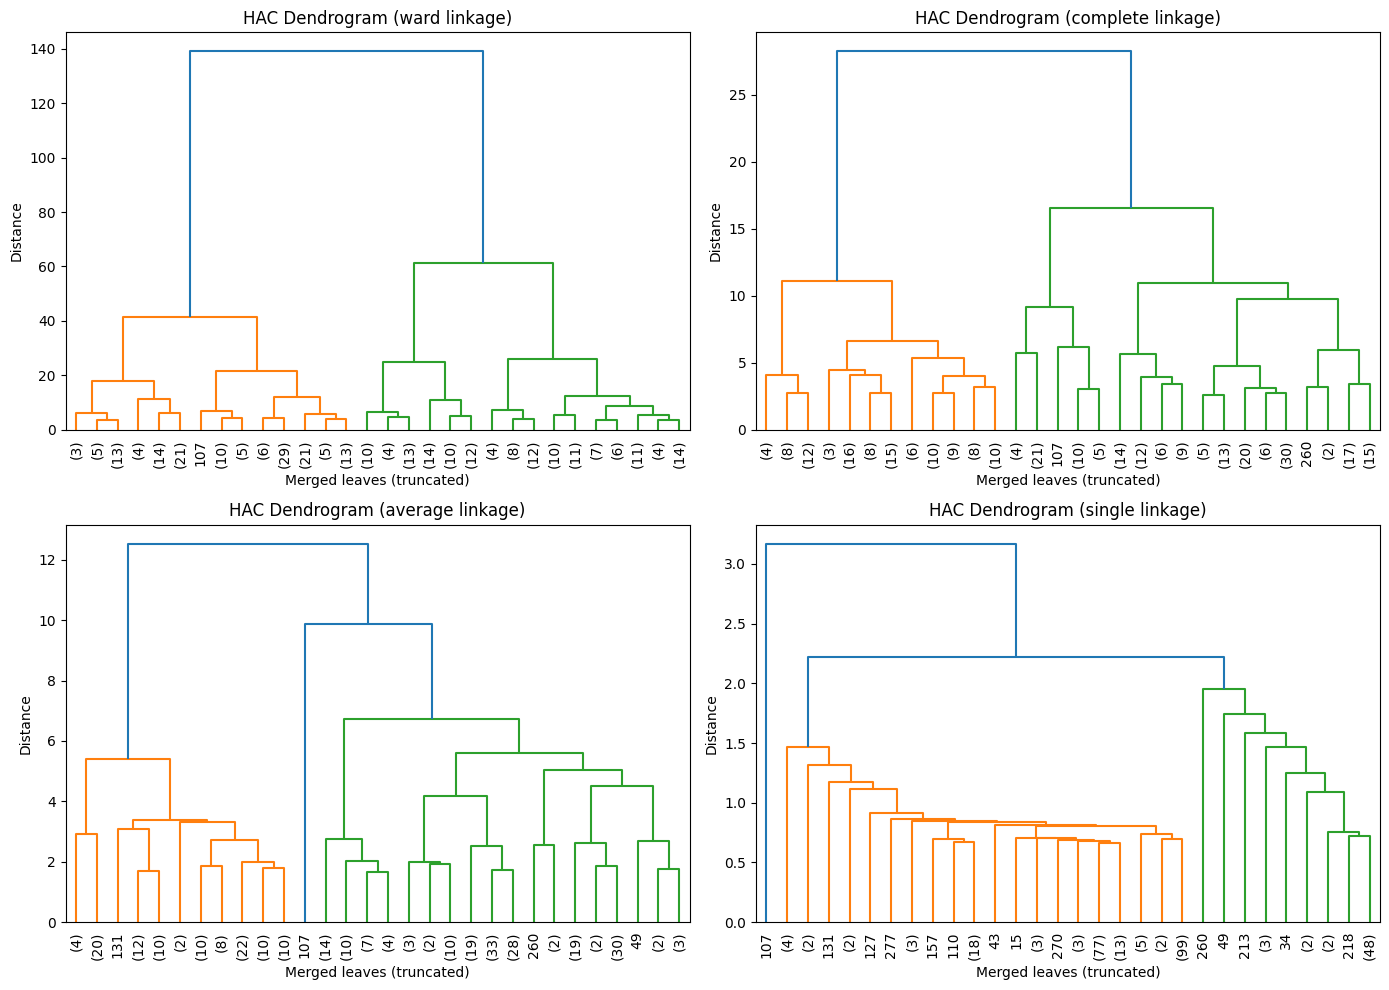


HAC quick evaluation at k=5:
  ward      silhouette=0.468  DB=0.686
  complete  silhouette=0.369  DB=0.963
  average   silhouette=0.499  DB=0.554
  single    silhouette=0.098  DB=0.691


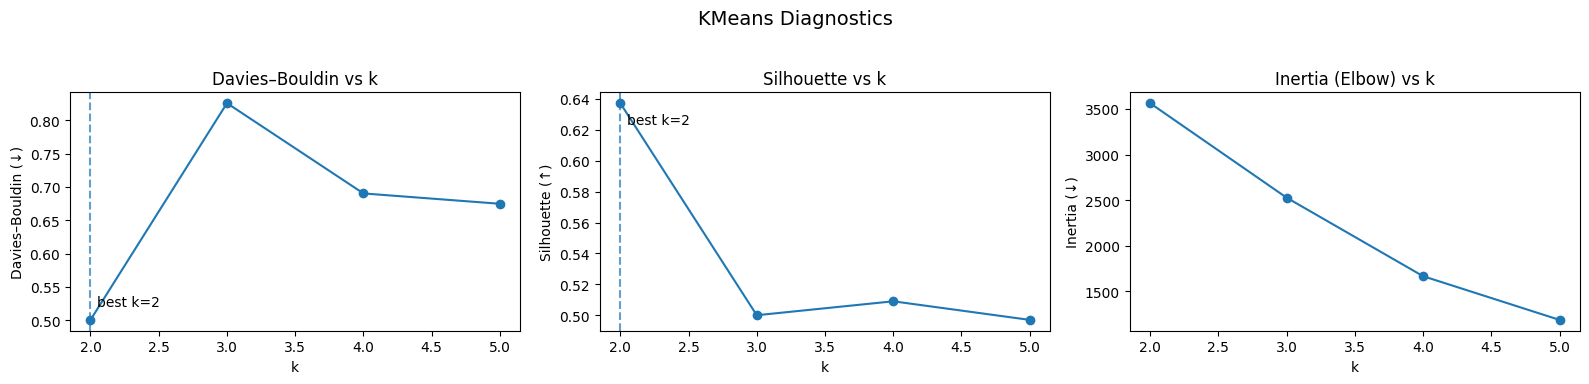


KMeans scores:
   k   inertia  silhouette  davies_bouldin
0  2  3563.539       0.637           0.500
1  3  2527.369       0.500           0.826
2  4  1665.911       0.509           0.690
3  5  1186.343       0.497           0.675


In [22]:
# Your code here

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# ---------------------------
# 1) Data
# ---------------------------
# Generate synthetic data with spherical clusters
X, y = make_blobs(n_samples=300, centers=5, cluster_std=2.0, random_state=42)

# Stretch and rotate some of the blobs to create elliptical clusters
transformation_matrix = np.array([[0.6, -0.6], [-0.2, 0.9]])
X_aniso = np.dot(X, transformation_matrix)

# ---------------------------
# 2) HAC dendrograms (4 linkages)
# ---------------------------
methods = ["ward", "complete", "average", "single"]

plt.figure(figsize=(14, 10))
for i, m in enumerate(methods, 1):
    Z = linkage(X_aniso, method=m)
    ax = plt.subplot(2, 2, i)
    dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90)
    ax.set_title(f"HAC Dendrogram ({m} linkage)")
    ax.set_xlabel("Merged leaves (truncated)")
    ax.set_ylabel("Distance")
plt.tight_layout()
plt.show()

# Optionally: cut dendrograms at k=5 (or any k) and evaluate HAC quickly
k_cut = 5
print(f"\nHAC quick evaluation at k={k_cut}:")
for m in methods:
    Z = linkage(X_aniso, method=m)
    labels = fcluster(Z, t=k_cut, criterion="maxclust")  # labels are 1..k
    # Re-index to 0..k-1 to be consistent
    labels = labels - labels.min()
    sil = silhouette_score(X_aniso, labels)
    db = davies_bouldin_score(X_aniso, labels)
    print(f"  {m:<8}  silhouette={sil:.3f}  DB={db:.3f}")

# ---------------------------
# 3) KMeans evaluation across k
# ---------------------------
ks = range(2, 6)
sil_vals, db_vals, inertia_vals = [], [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_aniso)
    inertia_vals.append(km.inertia_)
    sil_vals.append(silhouette_score(X_aniso, labels))
    db_vals.append(davies_bouldin_score(X_aniso, labels))

scores = pd.DataFrame({
    "k": list(ks),
    "inertia": inertia_vals,
    "silhouette": sil_vals,
    "davies_bouldin": db_vals
})

# Identify best k by internal metrics
k_best_sil = scores.loc[scores["silhouette"].idxmax(), "k"]
k_best_db  = scores.loc[scores["davies_bouldin"].idxmin(), "k"]

# ---------------------------
# 4) Plots for KMeans metrics
# ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("KMeans Diagnostics", fontsize=14)

# Davies–Bouldin (lower is better)
ax = axes[0]
ax.plot(scores["k"], scores["davies_bouldin"], marker="o")
ax.set_xlabel("k")
ax.set_ylabel("Davies–Bouldin (↓)")
ax.set_title("Davies–Bouldin vs k")
ax.axvline(k_best_db, linestyle="--", alpha=0.7)
ax.annotate(f"best k={k_best_db}", xy=(k_best_db, scores['davies_bouldin'].min()),
            xytext=(5, 10), textcoords="offset points")

# Silhouette (higher is better)
ax = axes[1]
ax.plot(scores["k"], scores["silhouette"], marker="o")
ax.set_xlabel("k")
ax.set_ylabel("Silhouette (↑)")
ax.set_title("Silhouette vs k")
ax.axvline(k_best_sil, linestyle="--", alpha=0.7)
ax.annotate(f"best k={k_best_sil}", xy=(k_best_sil, scores['silhouette'].max()),
            xytext=(5, -15), textcoords="offset points")

# Inertia (elbow)
ax = axes[2]
ax.plot(scores["k"], scores["inertia"], marker="o")
ax.set_xlabel("k")
ax.set_ylabel("Inertia (↓)")
ax.set_title("Inertia (Elbow) vs k")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nKMeans scores:")
print(scores.round(3))


Based on your inspection, how many clusters do you think you would guess if you weren't able to visualize the data?  What does this tell you about data-driven measures for cluster inference?

I would guess 5 based on how much they overlapped together, and 2 clusters are the most clearest classes chose by the metrics.This shows that data-driven measures for cluster inference are guidelines rather than rules — they can point you in the right direction, but rarely guarantee the “true” answer.